<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/22_end2end_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro


## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

In [99]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import os, pickle
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

in_colab = 'google.colab' in sys.modules   # check if note is executed within Colab

# Clone the repository if executed in Google Colab
if in_colab:  
    if "MLPy2021" in os.listdir():
        !git -C MLPy2021 pull
    else:
        !git clone https://github.com/munich-ml/MLPy2021/

# lib.helper_funcs.py. The import path depends on Colab or local execution 
if in_colab:
    from MLPy2021.lib.helper_funcs import plot_hist_2D
else: 
    from lib.helper_funcs import plot_hist_2D

# The import path depends on Colab or local execution
if in_colab:
    base_dir = os.path.join(os.getcwd(), "MLPy2021")
else:
    base_dir = os.getcwd()


Already up to date.


# Get the data

At this point the dataset has already been cloned from GitHub and is located in the `datasets` subdirectory:

In [100]:
data_dir = os.path.join(base_dir, "datasets")
os.listdir(data_dir)

['logfile.csv',
 'wavetrace_dq.dat',
 'wavetrace_rdqs.dat',
 'housing_dataset.pkl']

In [101]:
with open(os.path.join(data_dir, "housing_dataset.pkl"), "rb") as file:
    housing = pickle.load(file)

# A quick look at the data

The **housing dataset** contains house pricing data of about 20K districts in California. The type of the dataset is a Pandas DataFrame:

In [102]:
housing.shape

(20640, 10)

In [103]:
type(housing)

pandas.core.frame.DataFrame

In [104]:
housing.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [105]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Interpreting the `tail` and `info` printout:
- Each row (``index`` in Pandas) represents one district (one measurement in general)
- Each column represents one **attribute**
- The units of the attributes are mostly arbitrary
- The `total_bedrooms` attribute seems to be incomplete
- All attributes are numeric (`Dtype=float64`), except for `ocean_proximity`
- The `ocean_proximity` attribute contains text. It is no arbitrary text, but **categorical**:

In [106]:
set(housing["ocean_proximity"])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [107]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Exercise on Pandas

Show the 5 data samples with ``"ocean_proximity"`` being ``"ISLAND"``

#### Solution

In [108]:
mask = housing["ocean_proximity"] == "ISLAND"
housing.loc[mask, :]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
8314,-118.32,33.35,27.0,1675.0,521.0,744.0,331.0,2.1579,450000.0,ISLAND
8315,-118.33,33.34,52.0,2359.0,591.0,1100.0,431.0,2.8333,414700.0,ISLAND
8316,-118.32,33.33,52.0,2127.0,512.0,733.0,288.0,3.3906,300000.0,ISLAND
8317,-118.32,33.34,52.0,996.0,264.0,341.0,160.0,2.7361,450000.0,ISLAND
8318,-118.48,33.43,29.0,716.0,214.0,422.0,173.0,2.6042,287500.0,ISLAND


## Attribute histograms

Pandas offers build-in histgramm plots of all columns:

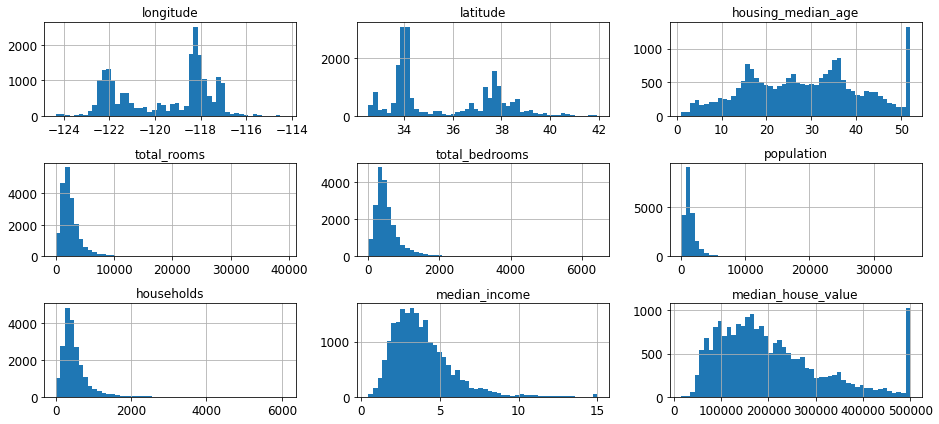

In [109]:
housing.hist(bins=50, figsize=(13, 6))
plt.tight_layout();  

Histogramms for **categorical features** have to be called from the **Series**: 

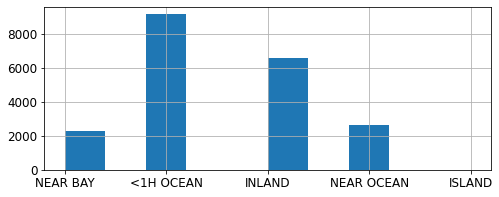

In [110]:
housing["ocean_proximity"].hist(figsize=(8,3));

#### Observations

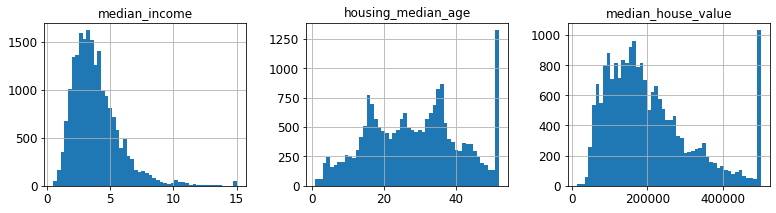

In [111]:
cols = ["median_income", "housing_median_age", "median_house_value"]
housing[cols].hist(bins=50, figsize=(13, 3), layout=(1, len(cols)));

Info given in the dataset describtion: The `median_income` unit is arbitrary. Furthermore, its values are capped at 15 (for high incomes) and 0.5 (for low incomes)


Obviously `housing_median_age` and `median_house_value` are capped, too. Could become a problem beause:

- `medial_house_value` will later be the **target attribute**, also called **label**
- the number of capped samples is significant




# Split data into **training** and **test** data


It is time to split the data set into a **training set** and a **test set** for final evaluation / test. 

![split_train_test.png](https://github.com/munich-ml/MLPy2021/blob/main/images/split_train_test.png?raw=1)

 

### Why splitting test data so early ?

Humans are strong in pattern recognition.

If the entire dataset is studied thoroughly, the data scientist may chose a paricular model that **overfits**.

The **generalization error** would be estimated too optimistic and the system would perform worse than expected on new data.



## Unterstanding `train_test_split`

In [112]:
from sklearn.model_selection import train_test_split

**`train_test_split`** features:
- Easy to use 'one-liner'
- **Randomly** splits data in an arbitrary size
- Reproducable splitting, so the model doesn't see more of the full dataset on each execution
- Multiple datasets can be split on the same indices (e.g. `features` and `labels`)

### Exercise `train_test_split`

Evaluate `train_test_split` function using some simple artificial dataset with the 200 labels being 0's followd by 100 1's.

In [113]:
N = 300
feature = np.arange(0, N, step=1)   # 0..N
labels = np.zeros_like(feature)
labels[feature > feature.max() * 2/3] = 1

In [114]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

1. Create a DataFrame ``dataset`` with the columns ``feature``. and ``labels``

1. Use ``train_test_split()`` into a ``train_set`` and a ``test_set`` of equal size. Use ``?`` for help.

1. Evaluate the histogramms from all three sets. Was the split successful?

#### Solution

In [115]:
dataset = pd.DataFrame(np.column_stack([feature, labels]), columns=["feature", "labels"])
dataset.iloc[[0, 1, 199, 200, -2, -1], :]

,feature,labels
0,0,0
1,1,0
199,199,0
200,200,1
298,298,1
299,299,1


In [116]:
train_set, test_set = train_test_split(dataset, test_size=0.5, random_state=4711)
train_set.head()

,feature,labels
279,279,1
169,169,0
42,42,0
262,262,1
94,94,0


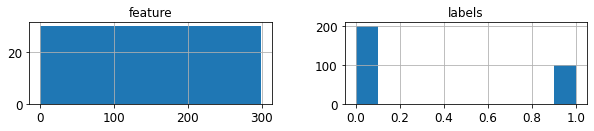

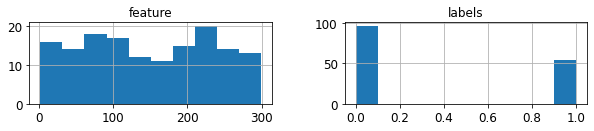

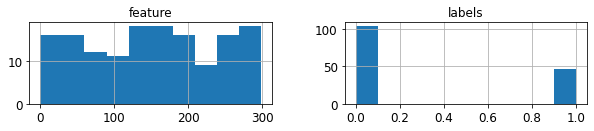

In [117]:
for set_ in (dataset, train_set, test_set):
    set_.hist(figsize=[10, 1.5])

`test_train_split` worked as expected:
- both subsets are ramdomly shuffled
- each of the subsets `train_set` and `test_set` contains about 100 0's and 50 1's
- executing `test_train_split` multiple times returns identical results

## Unterstanding `StratifiedShuffleSplit`

**Stratified sampling** ensures that the feature 
distributions are **representative**. 

The `test_train_split` function we used before didn't split the dataset represantatively:

In [118]:
train_set["labels"].sum()

54

In [119]:
test_set["labels"].sum()

46

... `54 / 46` instead of `50 / 50` is a significant difference and is called **sampling bias**.

The sampling bias effect is typically worse for smaller datasets.

Scikit-Learn incorporates the `StratifiedShuffleSplit` class, unfortunatelly without a handy one-liner function such as `test_train_split`. Thus the code is more complex:

In [120]:
from sklearn.model_selection import StratifiedShuffleSplit

In [121]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=23)
for train_index, test_index in split.split(dataset, dataset["labels"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

Checking the subsets reveals a perfectly representative `50 / 50` split: 

In [122]:
strat_train_set["labels"].sum()

50

In [123]:
strat_test_set["labels"].sum()

50

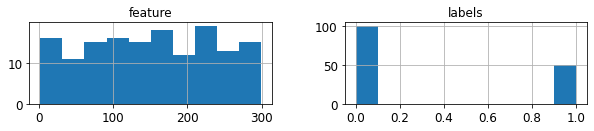

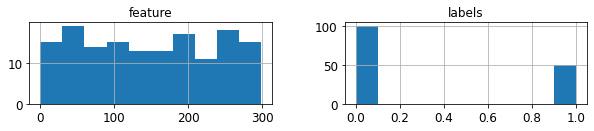

In [124]:
for set_ in (strat_train_set, strat_test_set):
    set_.hist(figsize=[10, 1.5])

## Applying `StratifiedShuffleSplit`

Applying `StratifiedShuffleSplit` to the housing data is a bit more complicated than for the simple `dataset`. It has to be decided on which feature to stratify on, an that feature needs to be *categorical*.

In this example:
- `"median_income"` is chosen a *stratification feature*
- `pd.cut` is used to cut is in bins in order to have it  *categorical*


Add a new cathegorical feature `income_cat`:

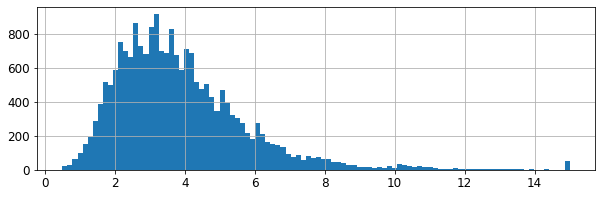

In [125]:
housing["median_income"].hist(bins=100, figsize=(10,3));

In [165]:
housing["income_cat"] = pd.cut(housing["median_income"], 
                               bins=[0., 1.5, 2.5, 3.5, 4.5, 6., np.inf])   

Split the `housing` dataset representatively to `income_cat`:

In [166]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [167]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
1516,-122.07,37.93,45.0,1544.0,244.0,614.0,238.0,5.0255,226000.0,NEAR BAY,"(4.5, 6.0]"
8955,-118.39,34.02,45.0,1577.0,421.0,1042.0,375.0,3.4375,314500.0,<1H OCEAN,"(2.5, 3.5]"
2143,-119.74,36.78,27.0,4049.0,947.0,2254.0,882.0,2.2467,70700.0,INLAND,"(1.5, 2.5]"
2179,-119.90,36.79,22.0,1970.0,332.0,1066.0,319.0,3.3125,106100.0,INLAND,"(2.5, 3.5]"
12479,-121.49,38.59,20.0,463.0,180.0,486.0,190.0,1.0313,85000.0,INLAND,"(0.0, 1.5]"


Finally, remove the `income_cat` feature.

In [168]:
for set_ in (housing, strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

The histogramms suggest that the represantative split was successful:

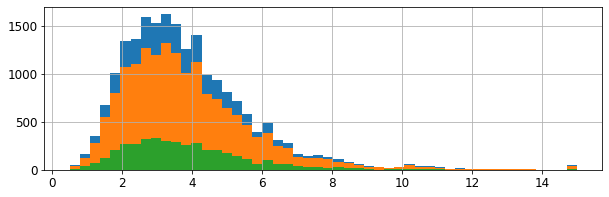

In [169]:
for set_ in (housing, strat_train_set, strat_test_set):
    set_["median_income"].hist(figsize=[10, 3], bins=50)

The test subset needs to be kept for later use!


In [170]:
strat_test_set.shape

(4128, 10)

The training subset is small enough to explore is small enough to explore is directly. Otherwise we would split a smaller *exploration subset*.

In [171]:
strat_train_set.shape

(16512, 10)

Now, we copy the training subset back to the more descriptive `housing` variable:

In [172]:
housing = strat_train_set.copy()

# Explore the data

In [174]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1516,-122.07,37.93,45.0,1544.0,244.0,614.0,238.0,5.0255,226000.0,NEAR BAY
8955,-118.39,34.02,45.0,1577.0,421.0,1042.0,375.0,3.4375,314500.0,<1H OCEAN
2143,-119.74,36.78,27.0,4049.0,947.0,2254.0,882.0,2.2467,70700.0,INLAND
2179,-119.90,36.79,22.0,1970.0,332.0,1066.0,319.0,3.3125,106100.0,INLAND
12479,-121.49,38.59,20.0,463.0,180.0,486.0,190.0,1.0313,85000.0,INLAND


There is geographical information in the dataset, so let's plot the map:

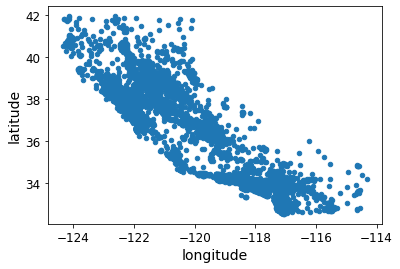

In [175]:
housing.plot(kind="scatter", x="longitude", y="latitude");

Use transparency (`alpha=0.1`) to see high-density areas better:

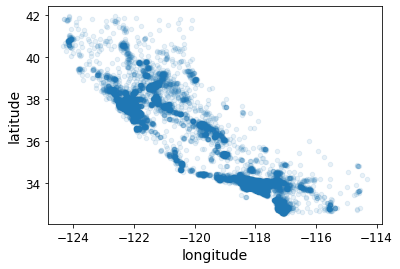

In [176]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

The following graph puts more information in the 2D graph:
- color: `median_house_value`, the target / label
- size: `population` of the district

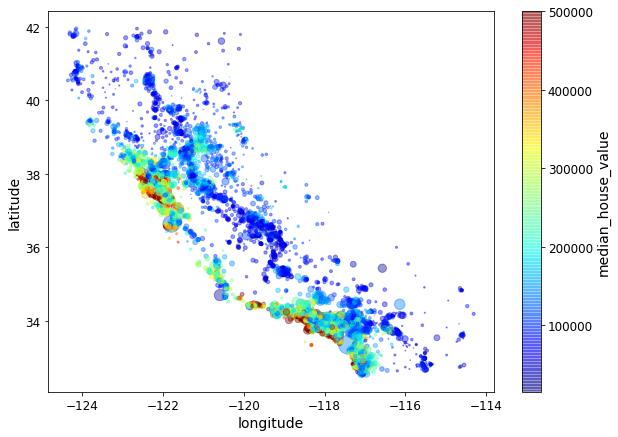

In [180]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             figsize=(10, 7), c="median_house_value", cmap=plt.cm.jet, colorbar=True, sharex=False);

Bugfix: Use `sharex=False`, otherwise the x-axis values and legend are not displayed (https://github.com/pandas-dev/pandas/issues/10611). 



The graph is even more self-explaining when overlayed with a map. In this example, the map is loaded as an image (`california.png`) and "aligned-by-hand":

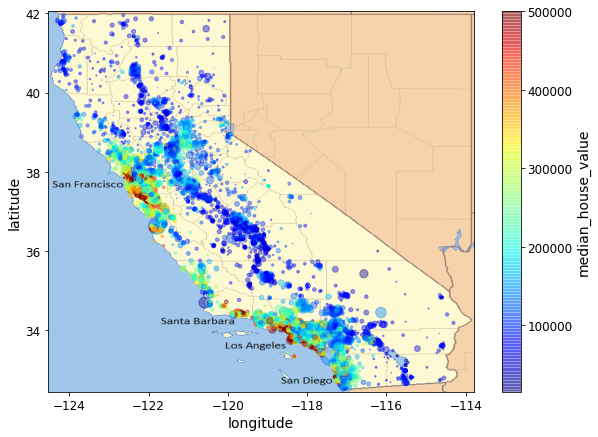

In [181]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             figsize=(10, 7), c="median_house_value", cmap=plt.cm.jet, colorbar=True, sharex=False)

plt.imshow(mpl.image.imread(os.path.join(base_dir, "images", "california.png")), 
           extent=[-124.55, -113.80, 32.45, 42.05]);

## Interpreting the map

- the `median_house_prices` are strongly related to location
- `ocean_proximity` could be helpful. Although there are low-value coastal areas, as well.
- a clustering algorithm should easily find high price areas and a new features with distances to these cluster centers would be useful 

## Correlations 

Computing the correlation coefficients is easy and can provide insides to feature-to-feature and feature-to-target assiciations. 


### Correlation coefficient
A **correlation coefficient $p$** shows how much two features' movements are associated *linearly*:

- $abs(p) < 0.1$: No relevant linear correlation
- $p > 0.5$: Strong plositive linear correlation
- $p < -0.5$: Strong negative linear correlation


#### Correlation of arbitrary functions

Let's simulate some arbitraty funcitons to get a feeling for the correlation coefficients:

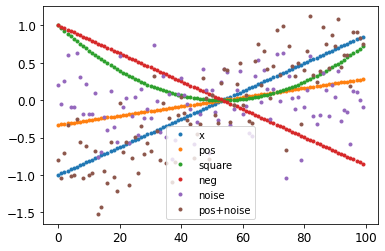

In [186]:
x = np.linspace(start=-1, stop=0.85, num=100)
np.random.seed(42)
noise = 0.4 * np.random.randn(x.size)
df = pd.DataFrame(np.column_stack([ x , 0.33*x,   x*x    ,  -x  ,  noise ,  x + noise]), 
                          columns=["x", "pos" ,  "square", "neg", "noise", "pos+noise"])
df.plot(style=".");

Panda DataFrames include a `corr` method for computing the pairwise correlation coefficients of the columns:

In [187]:
df.corr()["x"]

x            1.000000
pos          1.000000
square      -0.296924
neg         -1.000000
noise        0.044508
pos+noise    0.838436
Name: x, dtype: float64

Result discussion:
- Full correlation (+/-1) is given, regardless of the slope: E.g. $p(0.33*x)=p(x)=1$
- The `square` function exebits a relatively weak **linear** correlation (Strongly depencent on the x-axis section)
- Although quite noisy the `pos+noise` correlation is very strong.



### Applying `corr` to the `housing` dataset

In [188]:
housing.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
1516,-122.07,37.93,45.0,1544.0,244.0,614.0,238.0,5.0255,226000.0,NEAR BAY
8955,-118.39,34.02,45.0,1577.0,421.0,1042.0,375.0,3.4375,314500.0,<1H OCEAN
2143,-119.74,36.78,27.0,4049.0,947.0,2254.0,882.0,2.2467,70700.0,INLAND


In [189]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924294,-0.107665,0.049178,0.076006,0.104334,0.061416,-0.017820,-0.045476
latitude,-0.924294,1.000000,0.008336,-0.041078,-0.074068,-0.113203,-0.078187,-0.076844,-0.144906
housing_median_age,-0.107665,0.008336,1.000000,-0.360034,-0.320065,-0.294518,-0.302459,-0.110687,0.113154
total_rooms,0.049178,-0.041078,-0.360034,1.000000,0.929626,0.854955,0.917410,0.194433,0.132824
total_bedrooms,0.076006,-0.074068,-0.320065,0.929626,1.000000,0.874486,0.979250,-0.012600,0.047544
population,0.104334,-0.113203,-0.294518,0.854955,0.874486,1.000000,0.904454,-0.000178,-0.027956
households,0.061416,-0.078187,-0.302459,0.917410,0.979250,0.904454,1.000000,0.007937,0.064003
median_income,-0.017820,-0.076844,-0.110687,0.194433,-0.012600,-0.000178,0.007937,1.000000,0.688174
median_house_value,-0.045476,-0.144906,0.113154,0.132824,0.047544,-0.027956,0.064003,0.688174,1.000000


A heatmap of the correlation matrix is easier to evaluate. 

`Matplotlib` can show bitmaps by using the `imshow()` method. If the bitmap is a NumPy matrix you may call it a heatmap: 

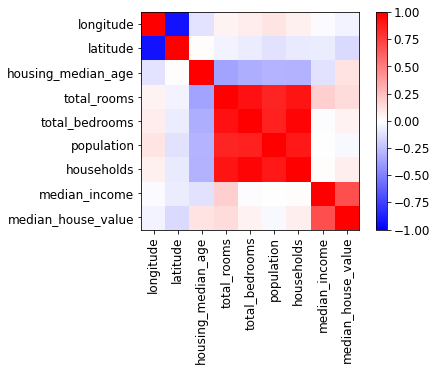

In [190]:
plt.imshow(corr_matrix, cmap=plt.cm.bwr)
plt.xticks(range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), labels=corr_matrix.index)
plt.clim([-1, 1])
plt.colorbar();

#### Evaluating the heatmap

1. There is a strong correlation between the four features `total_rooms`, `total_bedrooms`, `population` , `households`.

1. Also there is a strong negative correlation between `longitude` and `latitude`. This can be understood from the map of California from the previous chapter.

1. `median_house_value` is the **target**. Thus, features with high (positive or negative) correlation with `median_house_value` are of interest. The following sorted output shows that only `median_income` correlates significantly:

#### Correlation with "median_house_value"

The important correlation coefficients are those referencing to `median_house_value`:

In [191]:
corr_with_house_value = corr_matrix["median_house_value"].drop("median_house_value")
corr_with_house_value.sort_values(ascending=False)

median_income         0.688174
total_rooms           0.132824
housing_median_age    0.113154
households            0.064003
total_bedrooms        0.047544
population           -0.027956
longitude            -0.045476
latitude             -0.144906
Name: median_house_value, dtype: float64

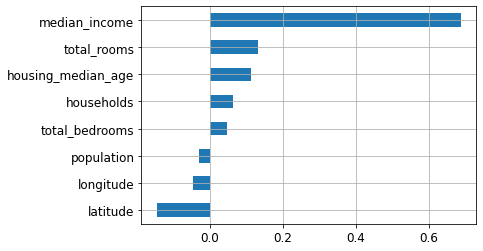

In [192]:
corr_with_house_value.sort_values().plot.barh(grid=True);

#### Interactive correlation matrix (optional)
For the usec-case of inspecting the four high-correlation-features in more detail, this subchapter adds interactive sliders to the color scale.

In [193]:
from ipywidgets import interact
from ipykernel.pylab.backend_inline import flush_figures

In [194]:
def plot_corr_matrix(color_min=-1, color_max=1):
    plt.imshow(corr_matrix.values, cmap="bwr")
    ticks = corr_matrix.columns
    plt.xticks(ticks=range(len(ticks)), labels=ticks, rotation=90)
    plt.yticks(ticks=range(len(ticks)), labels=ticks)
    plt.clim([color_min, color_max])
    plt.colorbar()
    flush_figures();

In [195]:
interact(plot_corr_matrix, color_min=(-1, 1, 0.01), color_max=(-1, 1, 0.01));

interactive(children=(FloatSlider(value=-1.0, description='color_min', max=1.0, min=-1.0, step=0.01), FloatSli…

## Scatter matrix

Pandas build-in `scatter_matrix` method allows quick visual evaluation of feature distributions and correlations:

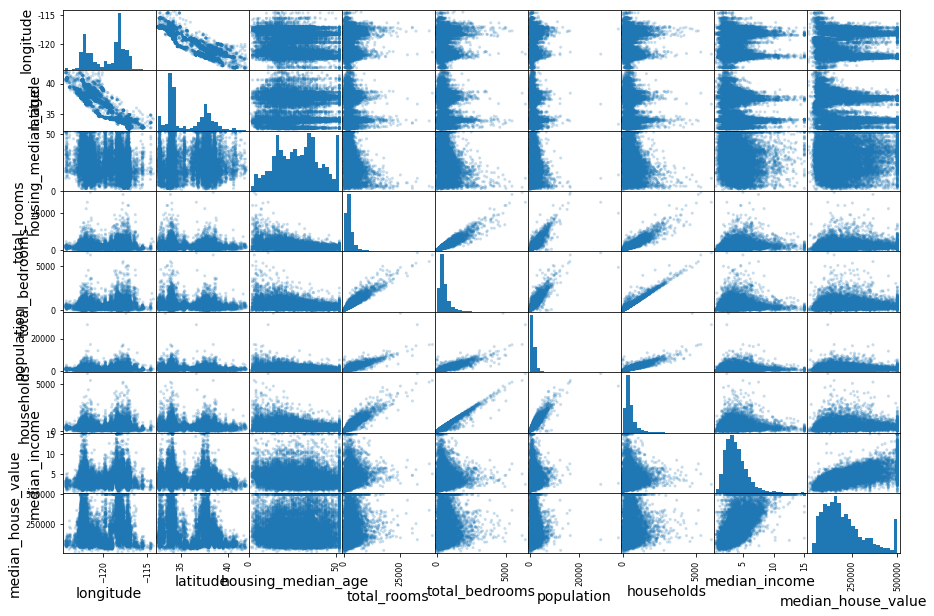

In [196]:
pd.plotting.scatter_matrix(housing, figsize=(15, 10), alpha=0.25, hist_kwds={"bins":25});

...one can clearly see the high correlation within the "4x4 center".

Let's look at a subset of the attributes more closely:

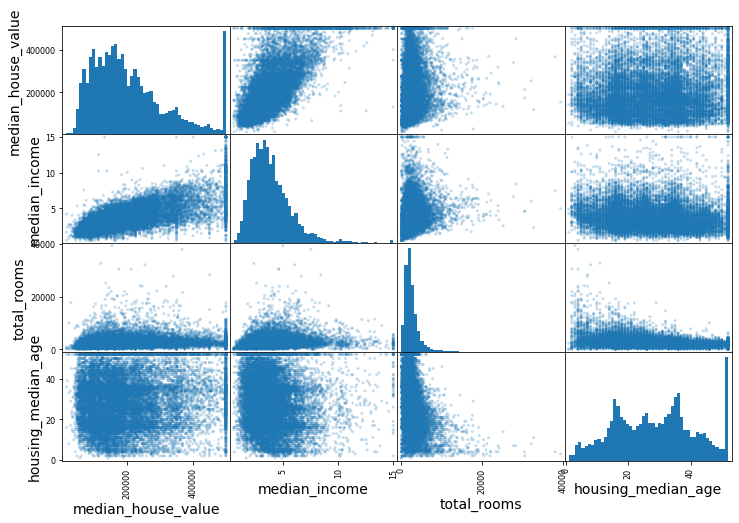

In [197]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8), alpha=0.25, hist_kwds={"bins":50});

Detailed evaluation of the __target__ `median_house_value` with the best-correlating __feature__ `median_income`:


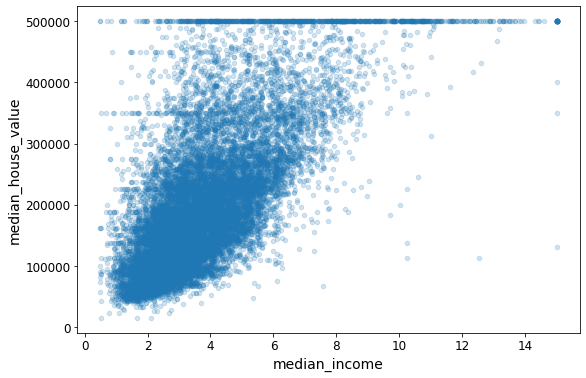

In [46]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.2, figsize=(9, 6), s=20);

###plot observations
What can be learned from the scatter-plot? 


- there is a strong correlation
- there seems to be a cap at y=500k (horizontal line)
- there are more horizontal lines (e.g. at 350k) which are probably artificial

### 2D histogram and contour plots

Plotting alternatives with `matplotlib`

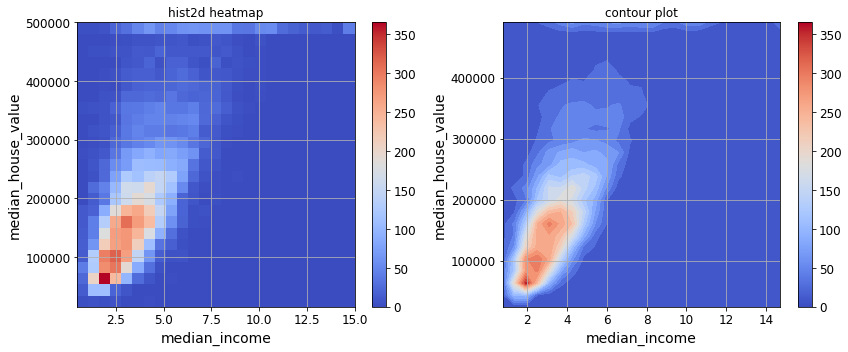

In [198]:
plot_hist_2D(housing, "median_income", "median_house_value", bins=25, figsize=[12, 5])

## Experimenting with feature combinations

Sometimes feature combinations are more useful in predicting the target, as the features by themself. 

An examples: `total_rooms` is the total number of rooms in a district. Dividing `total_rooms` by `households` (the number of households in the district) yields `rooms_per_household` and is probably more helpful in predicting the value of the house.


Before adding new features, let's make a copy of the `housing` dataset:

In [48]:
housing_copy = housing.copy(deep=True)

This, again, are the correlation coefficients of the native features:

In [49]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Adding new features:

In [50]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

... Note how readable the calculations are, using Pandas DataFrames.

Correlations coefficients including the new features:

In [51]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

Alternative (manual) printout that marks new features

In [52]:
new_features = set(housing.columns).difference(set(housing_copy.columns))
corr_dict = corr_matrix["median_house_value"].sort_values(ascending=False).to_dict()
for key, val in corr_dict.items():
    s = "{:30s}{:.3f}".format(key, val)
    if key in new_features:
        s += "  <-- new feature --"
    print(s)

median_house_value            1.000
median_income                 0.687
rooms_per_household           0.146  <-- new feature --
total_rooms                   0.135
housing_median_age            0.114
households                    0.065
total_bedrooms                0.048
population_per_household      -0.022  <-- new feature --
population                    -0.027
longitude                     -0.047
latitude                      -0.143
bedrooms_per_room             -0.260  <-- new feature --


###  New features scatter matrix (optional)

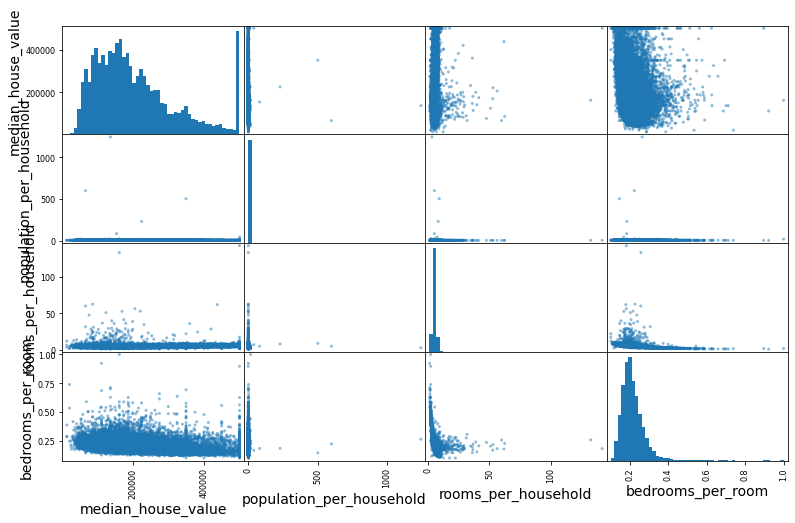

In [53]:
features = ["median_house_value"] + list(new_features)
pd.plotting.scatter_matrix(housing[features], figsize=(13, 8), alpha=0.5, hist_kwds={"bins":50});

# Prepare the data for Machine Learning algorithms

Seperate **features** and **labels** in the training set:

In [54]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [55]:
housing.shape

(16512, 9)

In [56]:
housing_labels.shape

(16512,)

##Data cleaning

###Missing values

Most Machine Learning algorithms cannot work with missing valus. 

As seen before, the `total_bedrooms` feature contains missing values:

In [57]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


**Find incomplete rows using `pd.DataFrame.isnull()` method**

In [58]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head(3)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN


#### Option 1: Drop rows 

Drop incomplete rows using `dropna()`

In [59]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


#### Option 2: Drop features


Drop incomplete features using `drop()`

Default axis is `0` or `index`, meaning rows.

Therefore chose `axis=1` or `column`.


In [60]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN


#### Option 3: `df.fillna()` 

Fill missing values using `fillna()` 
Assume the missing value to be zero, the mean, the median, etc

In [61]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN


As can be seen, imputing the median worked fine, BUT
- the median needs to be saved to fill-in missing values during prediction!
- during prediction, other features may contain missing values.

Thus, it's recommended to use existing **imputer** class, such as Scikit-learn's `SimpleImputer`

#### Option 4: `SimpleImputer`


Fill missing values with Scikit-learn `SimpleImputer`


In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:


In [63]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

In [64]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

... upon `imputer.fit()` the median of each attribute has been computed and stored in the `statistics_` variable:

In [65]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

The result should be identical to `df.median()` ...

In [66]:
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

The missing values are replaced using `transform` method:

In [67]:
X = imputer.transform(housing_num)

The result is a plain NumPy array and needs to be converted back to a pandas DataFrame.

In [68]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

Let's check the result on the `sample_incomplete_rows` subset:


In [69]:
housing_tr.loc[sample_incomplete_rows.index, :]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328


In [70]:
housing_tr.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621


###Handling Text and Categorical Attributes

Most Machine Learning algorithms requires numerical data.

The *housing dataset* contains one text feature `ocean_proximity`:

In [71]:
housing_cat = housing[("ocean_proximity")]
housing_cat.head(8)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
Name: ocean_proximity, dtype: object

The `ocean_proximity` feature is not arbitrary text. There are a limited number of possible values, each representing a *category*.

Use `set()` or the `Pandas.Series.unique` method to get the *unique* values of a collection: 

In [72]:
set(housing["ocean_proximity"])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [73]:
housing["ocean_proximity"].unique()

array(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'],
      dtype=object)

#### Ordinal encoder

The `OrdinalEncoder` replaces the category text by numbers.



In [74]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_enc = OrdinalEncoder()
housing_cat_encoded = ordinal_enc.fit_transform(housing_cat.values.reshape(-1, 1))

In [75]:
pd.DataFrame(housing_cat_encoded)[0].value_counts()

0.0    7276
1.0    5263
4.0    2124
3.0    1847
2.0       2
Name: 0, dtype: int64

In [76]:
housing_cat.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

Is this what we want? Probably not, because the Machine Learning algorithm that two nearby values are somehow similar. This might be desired in cases of sorted categories, but it usually isn't. In those cases, a `OneHotEncoder` can be used.

####OneHotEncoder

In [77]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

For memory reasons, the `OneHotEncoder` class returns a **sparse scipy array** instead of a **dense numpy array**.

Conversion to a dense array is provided by the `toarray()` method:


In [78]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [79]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

NumPy arrays can be ploted as image using Matplotlib and `imshow`:

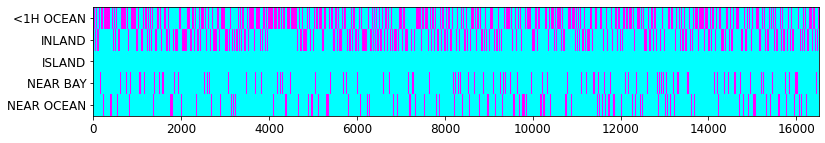

In [80]:
plt.figure(figsize=(13,2))
plt.imshow(housing_cat_1hot.toarray().T, interpolation='nearest', aspect='auto', cmap=plt.cm.cool)
cats = list(cat_encoder.categories_[0])
plt.yticks(range(len(cats)), labels=cats);

## Custom transformers

Further up this script we found **feature combinations** to be potentially helpful for predicting the target. 

Such **custom transformation functionality** can seamlessly work with **Scikit-Learn pipelines** by creating a **custom transformer class**.



In [81]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttrAdder(BaseEstimator, TransformerMixin):
    # column index
    INDEXES = {"rooms": 3, "bedrooms": 4, "population": 5, "households": 6}     

    def __init__(self):  # no *args or **kargs
        pass

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        i = CombinedAttrAdder.INDEXES
        rooms_per_household = X[:, i["rooms"]] / X[:, i["households"]]
        population_per_household = X[:, i["population"]] / X[:, i["households"]]
        bedrooms_per_room = X[:, i["bedrooms"]] / X[:, i["rooms"]]
        
        return np.column_stack((X, rooms_per_household, population_per_household, 
                                bedrooms_per_room))


Instanciating the new Transformer class ...


In [82]:
attr_adder = CombinedAttrAdder()
housing_extra_attr = attr_adder.fit_transform(housing.values)

Scikit-Learn transformers receive and return Numpy arrays. 



In [83]:
pd.DataFrame(housing_extra_attr).head()  # Conversion to DataFrame only for pretty plotting

,0,1,2,3,4,5,6,7,8,9,10,11
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944,0.223852
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796,0.159057
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597,0.241291
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598,0.200866
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785,0.231341


You have to keep track of the columns names, manually. This can easily get messy!

In [84]:
housing_columns = list(housing.columns) + ["rooms_per_household", "population_per_household", 
                                           "bedrooms_per_room"]
housing_columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity',
 'rooms_per_household',
 'population_per_household',
 'bedrooms_per_room']

In [85]:
housing_extra_attr = pd.DataFrame(housing_extra_attr, columns=housing_columns, index=housing.index)
housing_extra_attr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944,0.223852
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796,0.159057
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597,0.241291
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598,0.200866
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785,0.231341


... the resulting `housing_extra_attr` DataFrame contains the original as well as the extra attributes.

## Feature scaling

Most Machine Mearning algorithms require some kind of **features scaling**. With features of very different scales, they don't predict well or even don't converge at all. 

Some algorithms even require all features to be in the range of 0...1.

A notable exception are **decision tree algorithms** that are robust to arbitrarily scaled data.

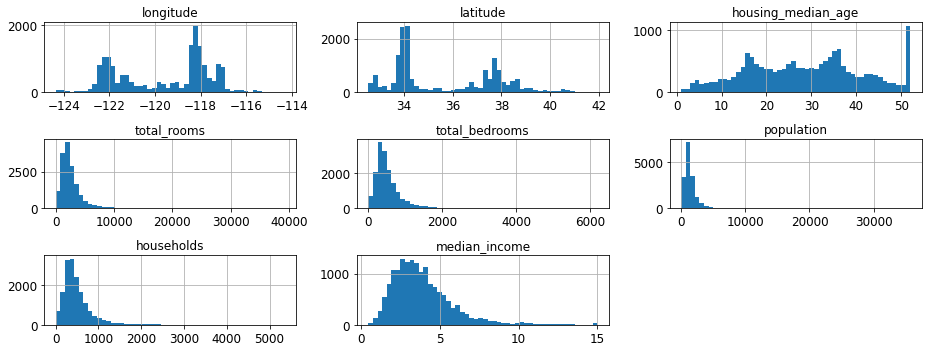

In [86]:
housing.hist(bins=50, figsize=(13, 5))
plt.tight_layout();

... yes, the scales of our `housing` dataset features are very different. Thus, scaling those features is requried.

Scikit-Learn provides various scalers, while the two common ones are `MinMaxScaler` and `StandardScaler`:  



In [87]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

Creating `plot_scaled_feature_hist`, a convinience function to evaluate the scalers' results:

In [88]:
def plot_scaled_feature_hist(scaler=None):
    df = housing.drop("ocean_proximity", axis=1)  # dropping the non-numeric feature
    if scaler is not None:
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df.hist(bins=50, figsize=(13, 4))
    plt.tight_layout();

The scaler is fitted only to the training data, excluding the test data! 

After `scalter.fit(training_data)`, the scalining parameters (`min, max, scale` in case of `MinMaxScaler`) are stored within the scaler object.

Those parameters can later be reused for transformations of test data or new data (in production). 

For comparison to the scaled features, let's plot the original histograms ones again:

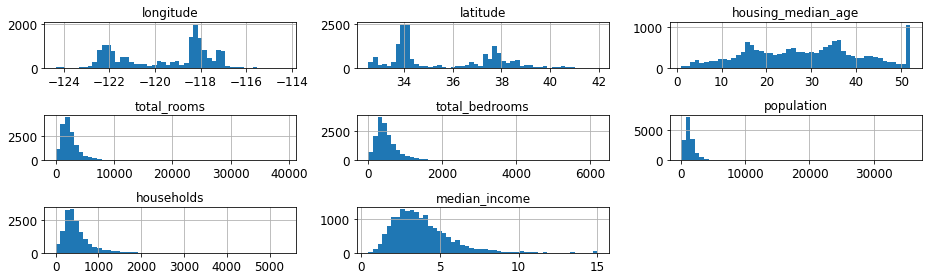

In [89]:
plot_scaled_feature_hist(scaler=None)  # original data without scaling

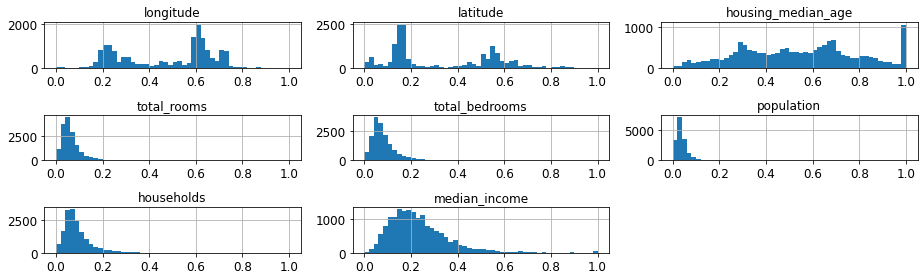

In [90]:
plot_scaled_feature_hist(scaler=MinMaxScaler())

... all features are scaled between 0 and 1.

Let's compare to *standardization*:

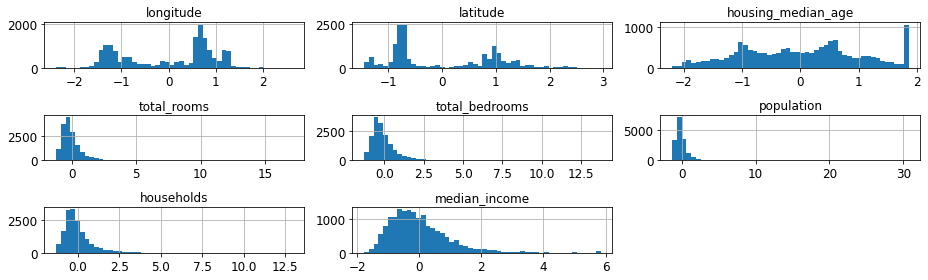

In [91]:
plot_scaled_feature_hist(scaler=StandardScaler())

... The results of `MinMaxScaler` and `StandardScaler` are very similar, just scale and offset are different.

These *linear scalers* preserve the original distribution. Sometimes odd distributions, such as the `total_bedrooms` disctibution shoud be avoided. The `QuantileTransformer` shapes the output distribution gaussion / `normal` or `uniform`:  



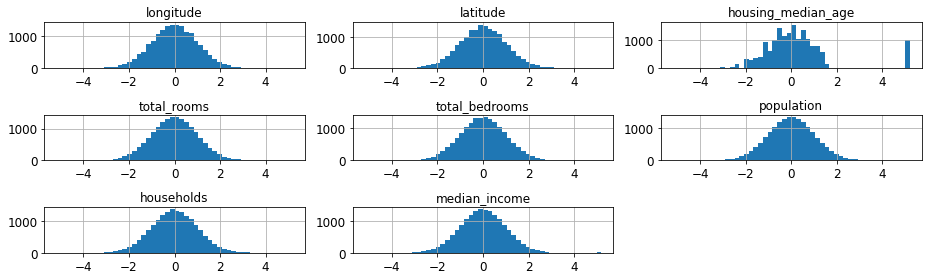

In [92]:
plot_scaled_feature_hist(scaler=QuantileTransformer(output_distribution="normal"))

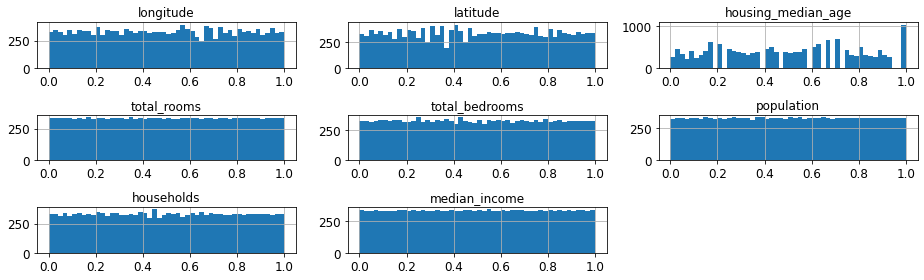

In [93]:
plot_scaled_feature_hist(scaler=QuantileTransformer(output_distribution="uniform"))

# Transformation pipelines

`Pipeline` is a Scikit-Learn class that executes data transformation steps in a defined order.

In [94]:
from sklearn.pipeline import Pipeline

The Pipeline constructor expects a list of name, transformer tuples:

In [95]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="median")),
                     ('attr_adder', CombinedAttrAdder()),
                     ('std_scaler', StandardScaler())])

Having generated the `num_pipi` pipeline, allows calling `fit()` and `fit_transform` on the pipeline object:

In [96]:
housing_num_tr = num_pipe.fit_transform(housing_num)

## Pipeline with categorical features

It would be even more convenient to have one combined pipeline for all features, numerical and categorical ones. Scikit-Learn's `ColumnTransformer` does exactly this.

In [97]:
from sklearn.compose import ColumnTransformer

In [98]:
num_attr = list(housing_num.columns)
cat_attr = ["ocean_proximity"]

In [99]:
full_pipe = ColumnTransformer([("num", num_pipe, num_attr),
                               ("cat", OneHotEncoder(), cat_attr)])

housing_prep = full_pipe.fit_transform(housing)

In [100]:
full_pipe

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0)),
                                                 ('attr_adder',
                                                  CombinedAttrAdder()),
                                                 ('std_scaler',
                                            

In [101]:
housing.shape

(16512, 9)

### Quiz
`housing` has 9 columns. How many does `housing_prep` have? 

In [102]:
housing_prep.shape

(16512, 16)

- 4 additional columns because of the `OneHotEncoder`: $number\_of\_categories - 1$
- 3 additional columns because of the `CombinedAttrAdder`



Again, we have to keep track of the column names manually:

In [103]:
pd.Series(housing_columns)   # pd.Series() used for pretty output, only

0                    longitude
1                     latitude
2           housing_median_age
3                  total_rooms
4               total_bedrooms
5                   population
6                   households
7                median_income
8              ocean_proximity
9          rooms_per_household
10    population_per_household
11           bedrooms_per_room
dtype: object

The extra attributes are in, but no yet the categorical attribus ...

In [104]:
cat_encoder = full_pipe.named_transformers_["cat"]
cat_columns = list(cat_encoder.categories_[0])
cat_columns

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [105]:
housing_prep_columns = housing_columns + cat_columns
housing_prep_columns.remove("ocean_proximity")
pd.Series(housing_prep_columns)   # pd.Series() used for pretty output, only

0                    longitude
1                     latitude
2           housing_median_age
3                  total_rooms
4               total_bedrooms
5                   population
6                   households
7                median_income
8          rooms_per_household
9     population_per_household
10           bedrooms_per_room
11                   <1H OCEAN
12                      INLAND
13                      ISLAND
14                    NEAR BAY
15                  NEAR OCEAN
dtype: object

# Select and train a model 

## Linear regression model

In [106]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prep, housing_labels);

... done! We got a simple but working Linear Regression. Let's try it on some instances from the test set:

In [107]:
n = 5
some_labels = strat_test_set["median_house_value"].iloc[:n]
some_data = strat_test_set.drop("median_house_value", axis=1).iloc[:n]
some_data_prep = full_pipe.transform(some_data)
some_predictions = lin_reg.predict(some_data_prep)

Note the beauty of the transformation pipeline. All data preparations are executed by simply calling `full_pipe.transform()`.

Now let's see how well it predicts:

In [108]:
a_trial = pd.DataFrame(np.column_stack((some_labels.values, some_predictions)), 
                       columns=["labels", "predictions"])
a_trial["error"] = a_trial["predictions"] - a_trial["labels"]
a_trial["error %"] = a_trial["error"] / a_trial["labels"] * 100
a_trial

,labels,predictions,error,error %
0,500001.0,424327.915871,-75673.084129,-15.134587
1,240300.0,264520.094254,24220.094254,10.079107
2,218200.0,228109.451560,9909.451560,4.541454
3,182100.0,202824.580607,20724.580607,11.380879
4,121300.0,164265.454243,42965.454243,35.420820


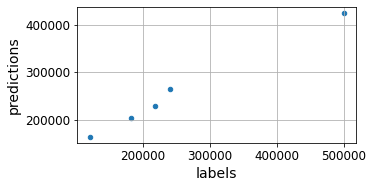

In [109]:
a_trial.plot("labels", "predictions", kind="scatter", grid=True, figsize=(5,2.5));

Not bad! There is at least basic functionality of the simple model.



## Root mean squared error

Scikit-Learn provides the `mean_squared_error` as a function, an NumPy will compute the square root:

$$\text{MSE}(y_\text{true}, y_\text{pred}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_\text{pred} - y_\text{true})^2$$


In [110]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE={:.1f}".format(rmse))
    return rmse

Let's measure the RMSE on the entire training set:

In [111]:
housing_predictions = lin_reg.predict(housing_prep)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions);

RMSE=68628.2


... is that number ok?

The RSME is the typical error of the prediction. It is an absolute accuracy measure, so we have to compare it's size to the labels size:

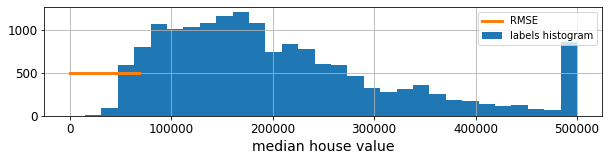

In [112]:
housing_labels.hist(bins=30, figsize=(10,2), label="labels histogram")
plt.plot([0, lin_rmse], [500, 500], linewidth=3, label="RMSE")
plt.xlabel("median house value"), plt.legend();

The RSME looks quite significant, when plotting it on top of the labels histogram. 

Thus, let's try a different model...

## Decisition tree model

A decision tree is a powerful machine learning model, capable of finding complex nonlinear relationships in the data. But for now, let's just use it and see how it performs:

In [113]:
from sklearn.tree import DecisionTreeRegressor

In [114]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prep, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [115]:
tree_rmse = root_mean_squared_error(housing_labels, tree_reg.predict(housing_prep));

RMSE=0.0


No error at all! 

We found the perfect model! ... Most likely not.

It is far more likely, that the model has badly overfit the data. In other words, the model just memorized the data without much generalization capability.

How can we be sure? 



## Model validation

How to **validate** model (e.g. *linear regression model* `lin_reg` and *decision tree model* `tree_reg`) without touching the **test set**?

Remember, the test set should be preserved for a final test right before going to production.

One common solution is to split the entire data set into 3 subsets:

![split_train_valid_test.png](https://github.com/munich-ml/MLPy2021/blob/main/images/split_train_valid_test.png?raw=1)

### Cross validation


The k-fold **cross validation** trains and validates a model k-times, each time with a differnet validation subset (called 'fold'). 

![images/split_cross_val.png](https://github.com/munich-ml/MLPy2021/blob/main/images/split_cross_val.png?raw=1)

- **advantage**: Cross validation provides not only the performance measure, but also an estimate of how precise that measure is (e.g. as a standard deviation).

- **disadvantage**: Cross validation executes `k`-times, so it may take a long time to finish.

In [116]:
from sklearn.model_selection import cross_val_score

In [117]:
# cross_val_score wrapper
# conveniently returning RSME (root mean squared error) as mean and standard
# deviation of the folds
def cross_validation(*args, **kwargs):
    scores = cross_val_score(*args, **kwargs,
                             scoring="neg_mean_squared_error")
    rmse = np.sqrt(-scores)
    print("Cross val mean(RMSE)={:.1f}, std(RMSE)={:.1f}".format(rmse.mean(), 
                                                                    rmse.std()))
    return {"mean":rmse.mean(), "std":rmse.std()}

In [118]:
tree_val_rsme = cross_validation(tree_reg, housing_prep, housing_labels, cv=5)

Cross val mean(RMSE)=71187.8, std(RMSE)=2110.5


Now, the *decision tree model* doesn't look as good anymore. 

- test / **in-sample** RSME is 0
- validation / **out-of-sample** RSME is large
- that model is clearly **overfitting** the data

It is even worse that the simple *linear regression model*:

In [119]:
lin_val_rmse = cross_validation(lin_reg, housing_prep, housing_labels, cv=5)

Cross val mean(RMSE)=69112.1, std(RMSE)=2193.1


#### Exercise 
Try to **regularize** the decision tree using its `min_samples_leaf` hyperparameter.

In [120]:
min_samples_leaf = [250, 100, 50, 30, 20, 10, 6, 3, 1]
tree_val_rsme_means = []
for msl in min_samples_leaf:
    tree_reg = DecisionTreeRegressor(random_state=42, min_samples_leaf=msl)
    tree_val_rsme = cross_validation(tree_reg, housing_prep, housing_labels, cv=5)
    tree_val_rsme_means.append(tree_val_rsme["mean"])

Cross val mean(RMSE)=66564.5, std(RMSE)=1867.8
Cross val mean(RMSE)=62383.2, std(RMSE)=2203.6
Cross val mean(RMSE)=59891.7, std(RMSE)=1871.7
Cross val mean(RMSE)=58309.7, std(RMSE)=1577.5
Cross val mean(RMSE)=58641.7, std(RMSE)=1384.6
Cross val mean(RMSE)=59348.7, std(RMSE)=1546.9
Cross val mean(RMSE)=60964.4, std(RMSE)=1790.1
Cross val mean(RMSE)=65376.4, std(RMSE)=1070.3
Cross val mean(RMSE)=71187.8, std(RMSE)=2110.5


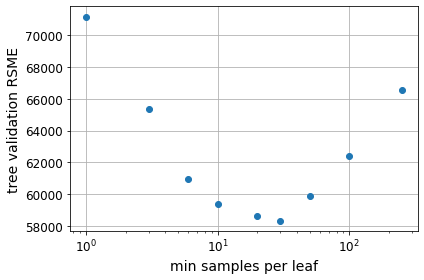

In [121]:
plt.semilogx(min_samples_leaf, tree_val_rsme_means, "o")
plt.xlabel("min samples per leaf"), plt.ylabel("tree validation RSME")
plt.grid(), plt.tight_layout();

This means the **DecisionTree** model can be improved significantly by **regulization**. 

## Random forest regression model

[Random forests on scikit-learn.org](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prep, housing_labels)
forest_rmse = root_mean_squared_error(housing_labels, forest_reg.predict(housing_prep));

RMSE=18603.5


In [124]:
forest_val_rmse = cross_validation(forest_reg, housing_prep, housing_labels, cv=5)

Cross val mean(RMSE)=50390.5, std(RMSE)=1373.0


## Support vector machine model

[SVM on scikit-learn.org](https://scikit-learn.org/stable/modules/svm.html#svm)

In [125]:
from sklearn.svm import SVR

In [126]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prep, housing_labels)
svm_rmse = root_mean_squared_error(housing_labels, svm_reg.predict(housing_prep))

RMSE=111094.6


In [127]:
svm_val_rmse = cross_validation(svm_reg, housing_prep, housing_labels, cv=5)

Cross val mean(RMSE)=112560.8, std(RMSE)=1584.5


## Comparing the models

In [128]:
pd.DataFrame([[lin_rmse, lin_val_rmse["mean"]], 
              [tree_rmse, tree_val_rsme["mean"]],
              [forest_rmse, forest_val_rmse["mean"]],
              [svm_rmse, svm_val_rmse["mean"]]],
             columns = ["in-sample RSME", "out-of-sample RSME"],
             index = ["linear regression", "decision tree", "random forest", "linear SVM"])

,in-sample RSME,out-of-sample RSME
linear regression,68628.198198,69112.081150
decision tree,0.000000,71187.799406
random forest,18603.515021,50390.535358
linear SVM,111094.630854,112560.833472


For now, the **random forest** is the most promising model. The fact that it's still overfitting shows that it can be further improved by **contraining**, or training to more data (which is often not possible).

For the **decision tree** it has already been shown, that it can be improved by **regulization**.

# Tune the model

**Tuning** the model means optimizing a **score** by varying the **hyperparameters**. In the *housing example* it's the RMSE that should be optimized / minimized.  

Tuning can be done manually or by using automized tools such as `GridSearchCV` or `RandomizedSearchCV`.

## GridSearchCV

The Scikit-Learn `GridSearchCV` automizes the tuning process:
- receive an `estimator` / a model to be tuned
- *fit* data to the model and *score* the predictions (the scorer ist set by `scoring`)
- execute the procedure for each combination of the `param_grid`
- *cross validation* is executed on each step with `cv` defining the number of *folds*


In [129]:
from sklearn.model_selection import GridSearchCV

Select an *estimator* / model and the respective *parameter grid* to be tuned:

In [130]:
forest_reg = RandomForestRegressor(random_state=42, bootstrap=False)

In [131]:
param_grid = {'n_estimators': [3, 10, 30], 
              'max_features': [2, 5, 8],
              'min_samples_leaf': [1, 3, 5]}

Note on **execution time**:

The `param_grid` in this example has `3 * 3 * 3 = 27` combinations and the cross validation folds are set `cv = 5` thus the time consuming training will be executed 135 times! 

The `verbose` parameter can be set (e.g. 1000) to get more info during execution. Using that it is easy to observe, that more complex models require more execution time.

In [132]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, return_train_score=True,
                           scoring='neg_mean_squared_error', verbose=0)

grid_search.fit(housing_prep, housing_labels);

### Evaluate `GridSearchCV` results

The best hyperparameter combination found:

In [133]:
grid_search.best_params_

{'max_features': 8, 'min_samples_leaf': 1, 'n_estimators': 30}

Details on the *cross validation* results are also available as `dict`. Converting to a `DataFrame` makes it more readable:

In [134]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.109756,0.002027,0.004635,0.000299,2,1,3,"{'max_features': 2, 'min_samples_leaf': 1, 'n_...",-3.785816e+09,-4.166012e+09,-4.061751e+09,-3.675704e+09,-4.089667e+09,-3.955790e+09,1.900964e+08,27,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
1,0.364560,0.007628,0.015036,0.001068,2,1,10,"{'max_features': 2, 'min_samples_leaf': 1, 'n_...",-2.810721e+09,-3.107789e+09,-3.131187e+09,-2.788537e+09,-3.099347e+09,-2.987516e+09,1.539234e+08,18,-6.056477e-02,-0.000000e+00,-0.000000e+00,-0.000000e+00,-2.967449e+00,-6.056027e-01,1.181156e+00
2,1.071085,0.010512,0.041599,0.000869,2,1,30,"{'max_features': 2, 'min_samples_leaf': 1, 'n_...",-2.541188e+09,-2.782024e+09,-2.831714e+09,-2.592330e+09,-2.782304e+09,-2.705912e+09,1.161807e+08,12,-3.797074e+00,-2.516298e+01,-0.000000e+00,-9.253932e+00,-3.733485e+02,-8.231249e+01,1.457708e+02
3,0.079562,0.004501,0.003130,0.000128,2,3,3,"{'max_features': 2, 'min_samples_leaf': 3, 'n_...",-3.723690e+09,-3.653646e+09,-3.715493e+09,-3.455474e+09,-3.634183e+09,-3.636497e+09,9.686229e+07,26,-1.532578e+09,-8.705910e+08,-8.815369e+08,-9.272360e+08,-9.031165e+08,-1.023012e+09,2.555200e+08
4,0.271039,0.003631,0.008861,0.000189,2,3,10,"{'max_features': 2, 'min_samples_leaf': 3, 'n_...",-2.910388e+09,-3.057091e+09,-3.037531e+09,-2.714423e+09,-3.022362e+09,-2.948359e+09,1.276078e+08,17,-7.989580e+08,-6.516007e+08,-6.407690e+08,-6.827879e+08,-6.711910e+08,-6.890613e+08,5.687077e+07
5,0.811121,0.001762,0.025218,0.000620,2,3,30,"{'max_features': 2, 'min_samples_leaf': 3, 'n_...",-2.686326e+09,-2.929300e+09,-2.893518e+09,-2.608893e+09,-2.886089e+09,-2.800825e+09,1.283087e+08,14,-6.601666e+08,-5.998220e+08,-6.283637e+08,-6.604725e+08,-6.076986e+08,-6.313047e+08,2.545910e+07
6,0.073014,0.005791,0.002696,0.000138,2,5,3,"{'max_features': 2, 'min_samples_leaf': 5, 'n_...",-3.733794e+09,-3.674615e+09,-3.438747e+09,-3.366019e+09,-3.740839e+09,-3.590803e+09,1.572453e+08,25,-2.245661e+09,-1.499630e+09,-1.353986e+09,-1.567451e+09,-1.481313e+09,-1.629608e+09,3.156703e+08
7,0.243643,0.006162,0.007521,0.000455,2,5,10,"{'max_features': 2, 'min_samples_leaf': 5, 'n_...",-2.892790e+09,-3.120835e+09,-3.045540e+09,-2.896905e+09,-3.154326e+09,-3.022079e+09,1.097056e+08,19,-1.417539e+09,-1.231708e+09,-1.185058e+09,-1.290886e+09,-1.182178e+09,-1.261474e+09,8.744674e+07
8,0.742053,0.010393,0.020418,0.000633,2,5,30,"{'max_features': 2, 'min_samples_leaf': 5, 'n_...",-2.724960e+09,-3.029725e+09,-2.947675e+09,-2.712201e+09,-3.058374e+09,-2.894587e+09,1.482868e+08,15,-1.233668e+09,-1.158973e+09,-1.125620e+09,-1.189840e+09,-1.194990e+09,-1.180618e+09,3.632968e+07
9,0.210550,0.006509,0.005087,0.000258,5,1,3,"{'max_features': 5, 'min_samples_leaf': 1, 'n_...",-3.488668e+09,-3.500410e+09,-3.599475e+09,-3.424466e+09,-3.503601e+09,-3.503324e+09,5.601250e+07,24,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00


#### Exercise  
Even as a `DataFrame` this is hard to evaluate.

**Task**: Write a `get_best_of_cv_results` function, that:
- takes the `dict` `grid_search.cv_results_` as input
- converts it to a `pandas.DataFrame`
- removes all unnecessary columns. Only keep those starting with `param_`
- creates a `RSME` column: `RSME = squareroot(- mean_test_score)`
- sorts by `RSME` with having the best on top
- returns that beautified `DataFrame`

In [135]:
def get_best_of_cv_results(results_dict):
    df_all = pd.DataFrame(results_dict)

    # select the columns to be kept
    cols = ["mean_test_score"]
    for col in df_all.columns:
        if col.startswith("param_"):
            cols.append(col)
    df = df_all.loc[:, cols]

    # remove "param_" in column names
    df.columns = [col.replace("param_", "") for col in df.columns]

    # convert negative mean squared error to RMSE
    df["RMSE"] = np.sqrt(-df["mean_test_score"])
    df.drop(labels="mean_test_score", axis=1, inplace=True)

    # sort by RMSE
    df.sort_values(by="RMSE", inplace=True)
    
    return df

In [136]:
get_best_of_cv_results(grid_search.cv_results_)

,max_features,min_samples_leaf,n_estimators,RMSE
20,8,1,30,48884.431623
23,8,3,30,49176.689939
26,8,5,30,49324.303287
11,5,1,30,49455.506238
14,5,3,30,49526.487323
17,5,5,30,50034.186398
25,8,5,10,50692.861335
22,8,3,10,50741.066730
19,8,1,10,50948.867601
13,5,3,10,51613.447777


Another helper function is created to visualize the results as heatmap:

In [137]:
def plot_pivot_heatmap(df, columns, index):
    pt = df.pivot_table(columns=columns, index=index, values="RMSE", aggfunc=np.min)
    plt.figure(figsize=(4, 2.5))
    plt.imshow(pt.values, interpolation='nearest', aspect='auto', cmap=plt.cm.coolwarm)
    plt.yticks(range(len(pt.index)), pt.index)
    plt.xticks(range(len(pt.columns)), pt.columns)
    plt.xlabel(columns), plt.ylabel(index)
    plt.colorbar()

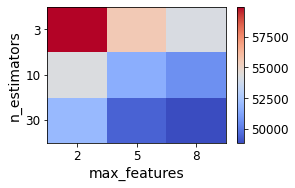

In [138]:
plot_pivot_heatmap(df=get_best_of_cv_results(grid_search.cv_results_), 
                   columns="max_features", index="n_estimators")

Obervation: The more complex the model gets, the better it predicts.

Interestingly, simple models (with a few estimators) perform better with higher min samples per leaf ...

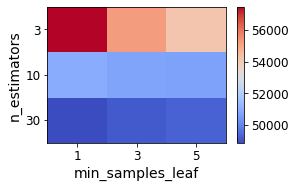

In [139]:
plot_pivot_heatmap(df=get_best_of_cv_results(grid_search.cv_results_), 
                   columns="min_samples_leaf", index="n_estimators")

### Best estimator

The **best estimator** found during `GridSearchCV` is dirctly available ...


In [140]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

## RandomizedSearchCV

`RandomizedSearchCV` implements a random alterative to the `GridSearchCV`. It is advantageous in case of many parameters and combinations and easier to scale to the available compute resources. 

In [141]:
from sklearn.model_selection import RandomizedSearchCV

In contrast to the `param_grid` of `GridSearchCV`, the `RandomizedSearchCV` expects a `param_distributions` `dict` with each `value` being a `list` or a distribution such as `scipy.stats.distributions`:

In [142]:
from scipy.stats import randint

param_distributions = {'n_estimators': randint(low=5, high=30),
                       'max_features': randint(low=1, high=8)}

In [143]:
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions, n_iter=15, cv=5, 
                                scoring='neg_mean_squared_error', random_state=42,
                                verbose=0)
rnd_search.fit(housing_prep, housing_labels);

### Evaluate `RandomizedSearchCV` results

,max_features,n_estimators,RMSE
0,7,24,50241.655518
4,7,23,50298.281876
3,5,25,50676.350141
1,5,19,51009.304196
14,5,16,51261.966916
5,7,15,51362.571248
6,3,28,51704.213894
8,3,26,51896.691532
10,4,10,52741.047043
7,5,8,53373.218001


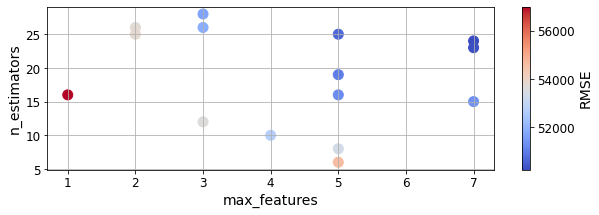

In [144]:
df = get_best_of_cv_results(rnd_search.cv_results_)
df.plot.scatter(x="max_features", y="n_estimators", 
                c="RMSE", s=100, cmap=mpl.cm.coolwarm,
                figsize=(10,3), grid=True, sharex=False)
df

Again, more complex models predict better than simple ones.

## Feature importance

The model we tuned with `GridSeachCV` and `RandomizedSearchCV` is the `RandomForestRegressor`. As a bycatch, that model indicates how important every feature is for making accurate predictions. Let's view them:


In [145]:
grid_search.best_estimator_.feature_importances_

array([7.88273169e-02, 6.88671378e-02, 4.19942712e-02, 1.49017795e-02,
       1.35027000e-02, 1.37463931e-02, 1.38703967e-02, 3.65660516e-01,
       5.60550742e-02, 1.06803673e-01, 4.91984306e-02, 6.03551591e-03,
       1.65945461e-01, 5.87295283e-05, 1.75702503e-03, 2.77557978e-03])

... for easy evaluation we need the column names along with the `feature_importances_` and also have them sorted: 

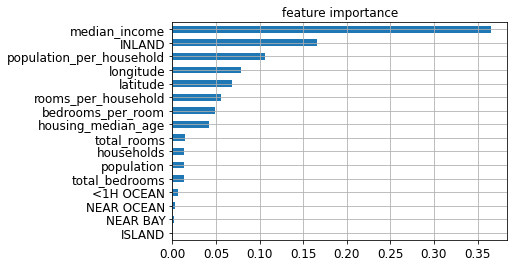

In [146]:
importances = pd.Series(grid_search.best_estimator_.feature_importances_, 
                        index=housing_prep_columns)
importances.sort_values(inplace=True)
importances.plot.barh(grid=True, title="feature importance");

### Evaluation

- `median_incame` stays the most important feature. This is somehow expected from the `corr_matrix` evaluation
- all three added features are in the upper half
- the `INLAND` 'bit' is 2nd most important. However, it seams all other categories could be dropped without losing much.

Let's plot again the linear correlations to the original features, for comparison:

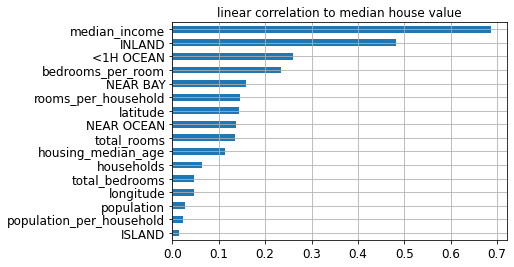

In [147]:
corr = pd.DataFrame(np.column_stack([housing_prep, housing_labels]), 
                    columns=housing_prep_columns + ["median_house_value"]).corr()
corr_value = corr["median_house_value"].drop("median_house_value")
corr_value.abs().sort_values().plot.barh(grid=True, 
                                         title="linear correlation to median house value");

In [148]:
df = pd.DataFrame(housing_prep, columns=housing_prep_columns)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928,1.0,0.0,0.0,0.0,0.0


... interrestingly, the worst correlating feature `population_per_household` became the 3rd most important feature, at least for the `RandomForestRegressor` model. 

Complex non-linear models don't rely on simple linear relationship!

In [149]:
set(importances.index).difference(set(corr_value.index))

set()

In [150]:
set(corr_value.index).difference(set(importances.index))

set()

In [151]:
corr_value

longitude                  -0.047432
latitude                   -0.142724
housing_median_age          0.114110
total_rooms                 0.135097
total_bedrooms              0.047642
population                 -0.026920
households                  0.064506
median_income               0.687160
rooms_per_household         0.146285
population_per_household   -0.021985
bedrooms_per_room          -0.234240
<1H OCEAN                   0.259521
INLAND                     -0.482886
ISLAND                      0.013709
NEAR BAY                    0.158733
NEAR OCEAN                  0.137378
Name: median_house_value, dtype: float64

### Exercise
How would you prove and visualize the high feature importance of "INLAND"

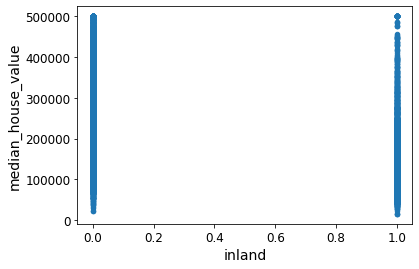

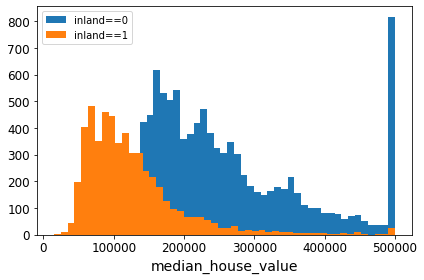

In [152]:
df = pd.DataFrame({"median_house_value": housing_labels,
                   "inland": housing_prep[:, housing_prep_columns.index("INLAND")]})
df.plot.scatter(x="inland", y="median_house_value")
plt.figure()
for inland in [0, 1]:
    plt.hist(df.loc[df["inland"]==inland, "median_house_value"], 
             bins=50, label="inland=="+str(inland))
    plt.xlabel("median_house_value"), plt.legend(), plt.tight_layout();

### Potential future improvements

- dropping unimportant features
- solve the clipping issue (esp. at 500.000)
- clean the data further (e.g. remove outliers)
- investigate the bad predictions and understand the root cause

# Final test

After tweaking your models for a while, you eventually decide that one of them performs *sufficiently* well. Then it's time to evaluate that final model with the test set. 

Once again, that must be the final step. Don't optimize any further on the test set!

In [153]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prep = full_pipe.transform(X_test)   # not .fit_transform() !
final_predictions = final_model.predict(X_test_prep)

final_rmse = root_mean_squared_error(y_test, final_predictions)

RMSE=46994.8


your model is ready for production!